In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

REG_COEFF = 1e-32


class ModifiedConvexRegression:

    def __init__(self, num_epochs=None):
        self.predictors_coeff = {}
        self.num_epochs = num_epochs

    def _boostrap(self, X, y):
        idx_boostrap = np.random.randint(0, self.num_objects, self.num_objects)
        X_boostrap = X[idx_boostrap]
        y_boostrap = y[idx_boostrap]
        return X_boostrap, y_boostrap

    def _make_predictors(self, X, y):
        predictors = []

        for idx_feature in range(self.num_features):
            predictor = LinearRegression()
            feature = X[:, idx_feature].reshape(-1, 1)
            predictor.fit(feature, y)
            predictors.append(predictor)

        self.predictors = np.array(predictors)

    def _get_variance_matrix(self, X_valid):
        variance_matrix = np.zeros(self.num_features)
        for idx_prediction in range(self.num_features):
            predictor = self.predictors[idx_prediction]

            predictions = []
            for idx_feature in range(self.num_features):
                feature = X_valid[:, idx_feature].reshape(-1, 1)
                prediction = predictor.predict(feature)
                predictions.append(prediction)

            predictions = np.array(predictions)
            variance_matrix[idx_prediction] = predictions.var()

        return variance_matrix

    def _get_distance_matrix(self, X_valid):
        distance_matrix = np.zeros((self.num_features, self.num_features))

        for idx_feature_1 in range(self.num_features):
            for idx_feature_2 in range(idx_feature_1 + 1, self.num_features):

                feature_1 = X_valid[:, idx_feature_1].reshape(-1, 1)
                feature_2 = X_valid[:, idx_feature_2].reshape(-1, 1)

                predictor_1 = self.predictors[idx_feature_1]
                predictor_2 = self.predictors[idx_feature_2]

                prediction_1 = predictor_1.predict(feature_1)
                prediction_2 = predictor_2.predict(feature_2)

                distance_matrix[idx_feature_1][idx_feature_2] = ((prediction_1 - prediction_2) ** 2).mean()

        distance_matrix += distance_matrix.T

        return distance_matrix

    def _get_thetas(self, variance_matrix, distance_matrix, y_valid):
        thetas_numerator = (-2) * distance_matrix * (variance_matrix[:, None] @ variance_matrix[None, :])
        variance_dif = variance_matrix[:, None] - variance_matrix[None, :]
        variance_sum = variance_matrix[:, None] + variance_matrix[None, :]
        thetas_denominator = (variance_dif ** 2 - distance_matrix * variance_sum + REG_COEFF)
        thetas = thetas_numerator / thetas_denominator

        condition = (thetas > variance_matrix[:, None]) * (thetas < variance_matrix[None, :])
        thetas = np.abs(thetas * (condition + condition.T))

        P_corr_numerator = (thetas / np.std(y_valid))
        denominator_numerator = (thetas - variance_matrix[:, None]) * (thetas - variance_matrix[None, :])
        denominator_denominator = variance_matrix[:, None] - variance_matrix[None, :] + REG_COEFF
        P_corr_denominator = (1 / (thetas - distance_matrix * (denominator_numerator / denominator_denominator ** 2) + REG_COEFF))
        P_corr = np.abs(P_corr_numerator * P_corr_denominator) ** 0.5
        V_corr = np.sqrt(variance_matrix) / np.std(y_valid)

        thetas *= (P_corr > V_corr[:, None]) + (P_corr > V_corr[None, :])
        return thetas

    def _get_k(self, theta, B):
        B_0, B_1, B_2 = B
        k = theta / np.sqrt((1 - B_1) * theta - B_2 * theta ** 2 - B_0)
        return k

    def _make_ensemble(self, ensemble, variance_matrix, distance_matrix):
        variance_matrix_save = variance_matrix
        variance_matrix = variance_matrix[ensemble, None]

        P = distance_matrix[ensemble][:, ensemble]
        try:
            P1 = np.linalg.inv(P)

        except Exception as exception:
            return

        alpha = variance_matrix.T @ P1 @ variance_matrix
        beta = np.sum(P1, axis=0) @ variance_matrix
        gamma = np.sum(P1)

        PHI = (P1 @ variance_matrix)[:, 0]
        PSI = np.sum(P1, axis=1)

        GAMMA_0 = ((alpha * PSI - beta * PHI) / (alpha * gamma - beta ** 2))[0]
        GAMMA_1 = ((gamma * PHI - beta * PSI) / (alpha * gamma - beta ** 2))[0]

        if ((GAMMA_0 < 0) * (GAMMA_1 < 0)).any():
            return

        mask = (GAMMA_0 < 0)
        thetas_interval = - GAMMA_0[mask] / GAMMA_1[mask]
        thetas_interval = thetas_interval[thetas_interval > 0]
        theta_min = np.max(thetas_interval)

        mask = (GAMMA_1 < 0)
        thetas_interval = - GAMMA_0[mask] / GAMMA_1[mask]
        thetas_interval = thetas_interval[thetas_interval > 0]
        theta_max = np.min(thetas_interval)

        B_0 = np.sum(GAMMA_0[:, None] @ GAMMA_0[None, :] * P1)
        B_1 = np.sum((GAMMA_0[:, None] @ GAMMA_1[None, :] + GAMMA_1[:, None] @ GAMMA_0[None, :]) * P1)
        B_2 = np.sum(GAMMA_1[:, None] @ GAMMA_1[None, :] * P1)
        B = (B_0, B_1, B_2)

        theta = (2 * B_0) / (1 - B_1)

        if theta < theta_min or theta > theta_max:
            return

        if self._get_k(theta, B) <= self._get_k(theta_min, B):
            return

        if self._get_k(theta, B) <= self._get_k(theta_max, B):
            return

        coeff = GAMMA_0 + GAMMA_1 * theta

        ensemble_last_idx = tuple(sorted(ensemble[:-1]))
        if ensemble_last_idx in self.predictors_coeff:
            del self.predictors_coeff[ensemble_last_idx]

        ensemble_new_idx = tuple(sorted(ensemble))
        if ensemble_new_idx in self.predictors_coeff:
            self.predictors_coeff[ensemble_new_idx].append(coeff)
        else:
            self.predictors_coeff[ensemble_new_idx] = [coeff]

        for feature_new_idx in range(self.num_features):
            if feature_new_idx not in ensemble:
                ensemble_new = ensemble.copy()
                ensemble_new.append(feature_new_idx)
                self._make_ensemble(ensemble_new, variance_matrix_save, distance_matrix)

    def _get_pair_max(self, distance_matrix, thetas):
        pair_max = [-1, -1]
        distance_max = -np.inf

        thetas = thetas.nonzero()
        for pair in zip(*thetas):
            pair = list(pair)
            distance = distance_matrix[pair[0], pair[1]]

            if distance > distance_max:
                distance_max = distance
                pair_max = pair

        return pair_max

    def _make_ensemble_pair(self, variance_matrix, distance_matrix, thetas, pair):
        predictor_idx_1 = pair[0]
        predictor_idx_2 = pair[1]

        coeff_numerator = thetas[predictor_idx_1][predictor_idx_2] - variance_matrix[predictor_idx_1]
        coeff_denominator = variance_matrix[predictor_idx_2] - variance_matrix[predictor_idx_1]
        coeff = coeff_numerator / coeff_denominator

        pair_new = tuple(sorted(pair))
        if pair_new in self.predictors_coeff:
            self.predictors_coeff[pair_new].append([coeff, 1 - coeff])
        else:
            self.predictors_coeff[pair_new] = [[coeff, 1 - coeff]]

        for idx_new in range(self.num_features):
            if idx_new in pair:
                continue

            ensemble_new = pair.copy()
            ensemble_new.append(idx_new)
            self._make_ensemble(ensemble_new, variance_matrix, distance_matrix)

    def _make_predictors_coeff(self):
        for key, value in self.predictors_coeff.items():
            value = np.array(value)
            self.predictors_coeff[key] = list(np.mean(value, axis=0))

    def _get_corr_coeff(self, X, y):
        corr_coeffs = []

        for (predictor_idxs, coeffs) in self.predictors_coeff.items():
            predictions = np.zeros_like(y)

            for idx, predictor_idx in enumerate(predictor_idxs):
                predictor = self.predictors[predictor_idx]
                prediction = predictor.predict(X[:, predictor_idx].reshape(-1, 1))
                predictions += prediction * coeffs[idx]

            corr_coeff = np.corrcoef(predictions, y)[0][1]
            corr_coeffs.append(corr_coeff)

        self.corr_coeffs = np.array(corr_coeffs)

    def _get_feature_prediction(self, X, tau):
        all_predictions = []

        for (predictor_idxs, coeffs) in self.predictors_coeff.items():
            predictions = np.zeros(X.shape[0])

            for idx, predictor_idx in enumerate(predictor_idxs):
                predictor = self.predictors[predictor_idx]
                prediction = predictor.predict(X[:, predictor_idx].reshape(-1, 1))
                predictions += prediction * coeffs[idx]

            all_predictions.append(predictions)
        all_predictions = np.array(all_predictions)

        mask = (self.corr_coeffs > tau * np.max(self.corr_coeffs))
        feature_prediction = (all_predictions[mask] * (1 - self.corr_coeffs[mask] ** 2)[:, None]).sum(axis=0)
        return feature_prediction

    def _get_tau_best(self, X, y):
        tau_best = 0
        corr_best = 0

        for tau in np.linspace(0, 1, 1000):
            y_valid_predicted = self._get_feature_prediction(X, tau)
            corr = np.abs(np.corrcoef(y_valid_predicted, y_valid)[0, 1])

            if corr > corr_best:
                corr_best = corr
                tau_best = tau

        return tau_best, corr_best

    def fit(self, X_train, y_train, X_valid, y_valid):
        self.num_objects, self.num_features = X_train.shape
        self.X_valid = X_valid
        self.y_valid = y_valid

        if not self.num_epochs:
            self.num_epochs = 2 * self.num_features

        for epoch in range(self.num_epochs):
            X_train_boostrap, y_train_boostrap = self._boostrap(X_train, y_train)
            self._make_predictors(X_train_boostrap, y_train_boostrap)
            variance_matrix = self._get_variance_matrix(X_valid)
            distance_matrix = self._get_distance_matrix(X_valid)
            thetas = self._get_thetas(variance_matrix, distance_matrix, y_valid)
            pair = self._get_pair_max(distance_matrix, thetas)
            self._make_ensemble_pair(variance_matrix, distance_matrix, thetas, pair)
        self._make_predictors_coeff()

        self._get_corr_coeff(X_valid, y_valid)
        self.tau, self.corr_valid = self._get_tau_best(X_valid, y_valid)

        feature_train = self._get_feature_prediction(X_train, self.tau)
        self.linear_transformation = LinearRegression()
        self.linear_transformation.fit(feature_train.reshape(-1, 1), y_train)

    def predict(self, X):
        self.feature_test = self._get_feature_prediction(X, self.tau)
        prediction = self.linear_transformation.predict(self.feature_test.reshape(-1, 1))
        return prediction

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

class VPK():

    def __init__(self, mode='corr', tau=0):
        self.ans = {}
        self.head = LinearRegression()
        self.mode = mode
        self.tau = tau

    def _create_predictors(self, X_train, y_train):
        predictors = []
        for i in range(self.n_features):
            regression = LinearRegression()
            regression.fit(X_train[:, i].reshape(-1, 1), y_train)
            predictors.append(regression)

        self.predictors = np.array(predictors)

    def _get_vars(self, X_valid):
        vars = np.zeros(self.n_features)
        for i in range(self.n_features):
            predictor = self.predictors[i]
            preds = []
            for j in range(self.n_features):
                x = X_valid[:, j].reshape(-1, 1)
                preds.append(predictor.predict(x))
            preds = np.array(preds)
            vars[i] = preds.var()
        self.vars = vars

    def _get_dists(self, X_valid):
        dists = np.zeros((self.n_features, self.n_features))
        for i in range(self.n_features):
            for j in range(i+1, self.n_features):
                x_i = X_valid[:, i].reshape(-1, 1)
                x_j = X_valid[:, j].reshape(-1, 1)
                predictor1, predictor2 = self.predictors[i], self.predictors[j]
                pred1, pred2 = predictor1.predict(x_i), predictor2.predict(x_j)
                dists[i][j] = ((pred1 - pred2)**2).mean()
        dists += dists.T
        self.dists = dists

    def _get_thetas(self, y_valid):
        thetas = ((-2) * self.dists * (self.vars[:, None] @ self.vars[None, :])) / ((self.vars[:, None] - self.vars[None, :])**2 - self.dists * (self.vars[:, None] + self.vars[None, :]) + 1e-32)

        good_thetas = np.abs(thetas * (
                    (thetas > self.vars[:, None]) * (thetas < self.vars[None, :]) + \
                    ((thetas > self.vars[:, None]) * (thetas < self.vars[None, :])).T)
              )
        cor_P = np.abs((good_thetas / np.std(y_valid)) * \
                (1 / (good_thetas - self.dists * ((good_thetas - self.vars[:, None]) * \
                (good_thetas - self.vars[None, :]) / (self.vars[:, None] - self.vars[None, :] + 1e-32)**2) + 1e-32)))**0.5
        cor_V = np.sqrt(self.vars) / np.std(y_valid)

        good_thetas = good_thetas * ((cor_P > cor_V[:, None]) + (cor_P > cor_V[None, :]))

        self.thetas = good_thetas

    def k(self, theta, B):
        B0, B1, B2 = B
        return theta / np.sqrt((1 - B1) * theta - B2 * theta**2 - B0)

    def create_ensemble(self, ensemble, vars, dists):
        P = dists[ensemble][:, ensemble]
        try:
            P1 = np.linalg.inv(P)
        except Exception as e:
            print('Can not revers dists matrix')
            return

        cur_vars = vars[ensemble, None]
        alpha = (cur_vars.T @ P1 @ cur_vars)
        beta = (np.sum(P1, axis=0) @ cur_vars)
        gamma = np.sum(P1)

        PHI = (P1 @ cur_vars)[:, 0]
        PSI = np.sum(P1, axis=1)

        GAMMA0 = ((alpha * PSI - beta * PHI) / (alpha * gamma - beta**2))[0]
        GAMMA1 = ((gamma * PHI - beta * PSI) / (alpha * gamma - beta**2))[0]

        if ((GAMMA0 < 0) * (GAMMA1 < 0)).any():
            return

        mask = GAMMA0 < 0

        thetas_interval = - GAMMA0[mask] / GAMMA1[mask]
        thetas_interval = thetas_interval[thetas_interval > 0]

        theta_min = np.max(thetas_interval)

        mask = GAMMA1 < 0

        thetas_interval = - GAMMA0[mask] / GAMMA1[mask]
        thetas_interval = thetas_interval[thetas_interval > 0]

        theta_max = np.min(thetas_interval)

        B0 = np.sum(GAMMA0[:, None] @ GAMMA0[None, :] * P1)
        B1 = np.sum((GAMMA0[:, None] @ GAMMA1[None, :] + GAMMA1[:, None] @ GAMMA0[None, :]) * P1)
        B2 = np.sum(GAMMA1[:, None] @ GAMMA1[None, :] * P1)
        B = (B0, B1, B2)

        theta = (2 * B0) / (1-B1)

        if theta < theta_min or theta > theta_max:
            return
        if (1 - B1) * theta - B2 * theta**2 - B0 < 0:
            return

        if self.k(theta, B) <= self.k(theta_min, B):
            return

        if self.k(theta, B) <= self.k(theta_max, B):
            return

        c = GAMMA0 + GAMMA1 * theta

        if tuple(sorted(ensemble[:-1])) in self.ans.keys():
            del self.ans[tuple(sorted(ensemble[:-1]))]

        self.ans[tuple(sorted(ensemble))] = c
        for i in range(self.n_features):
            if i not in ensemble:
                new_ensemble = ensemble.copy()
                new_ensemble.append(i)
                self.create_ensemble(new_ensemble, vars, dists)

    def _start(self):
        s = set()
        for pair in zip(*self.thetas.nonzero()):
            list_pair = list(pair)
            if tuple(sorted(list_pair)) not in s:

                c1 = (self.thetas[list_pair[0]][list_pair[1]] - self.vars[list_pair[0]]) / (self.vars[list_pair[1]] - self.vars[list_pair[0]])
                self.ans[tuple(sorted(list_pair))] = [c1, 1 - c1]
                for new_index in range(self.n_features):
                    if new_index in list_pair:
                        continue
                    list_three = list_pair.copy()
                    list_three.append(new_index)
                    self.create_ensemble(list_three, self.vars, self.dists)

                s.add(tuple(list(pair)))

    def _get_cor_coefs(self, X_valid, y_valid):
        corr_coefs = []
        for item in self.ans.items():
            indeces, c = item
            pred = np.zeros_like(y_valid)
            for i, ind in enumerate(indeces):
                pred += self.predictors[ind].predict(X_valid[:, ind].reshape(-1, 1)) * c[i]
            corr_coefs.append(np.corrcoef(pred, y_valid)[0][1])

        self.corr_coefs = np.array(corr_coefs)

    def fit(self, X_train, y_train, X_valid, y_valid):
        self.n_features = X_train.shape[1]
        self._create_predictors(X_train, y_train)
        self._get_vars(X_valid)
        self._get_dists(X_valid)
        self._get_thetas(y_valid)
        self._start()
        self._get_cor_coefs(X_valid, y_valid)
        y_train_preds = self._predict_without_head(X_train)
        self.head.fit(y_train_preds.reshape(-1, 1), y_train)


    def _predict_without_head(self, X):
        all_preds = []
        for item in self.ans.items():
            indeces, c = item
            pred = np.zeros(X.shape[0])
            for i, ind in enumerate(indeces):
                pred += self.predictors[ind].predict(X[:, ind].reshape(-1, 1)) * c[i]
            all_preds.append(pred)

        all_preds = np.array(all_preds)

        if self.mode == 'mean':
            return all_preds.mean(axis=0)[:, None]
        elif self.mode == 'corr':
            mask = np.abs(self.corr_coefs) > self.tau * np.max(np.abs(self.corr_coefs))
            return (all_preds[mask] * (1 - self.corr_coefs[mask]**2)[:, None]).sum(axis=0)[:, None]


    def predict(self, X):
        return self.head.predict(self._predict_without_head(X))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_squared_error
import time

In [ ]:
def generate_data(num_good_features, num_bad_features, num_objects=90, seed=None):
    if seed:
        np.random.seed(seed)

    X_good = np.random.uniform(-10, 10, size=(num_objects, num_good_features))
    X_bad = np.random.uniform(-10, 10, size=(num_objects, num_bad_features))

    w = np.random.normal(0, 3, num_good_features)
    b = np.random.normal(0, 3, 1)
    y = X_good @ w + b + np.random.normal(0, 30, num_objects)
    X = np.hstack([X_good, X_bad])

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.67)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.5)

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [ ]:
def f(X):
    w = np.random.normal(0, 3, X.shape[1])
    b = np.random.normal(0, 3, 1)
    return X @ w + b + np.random.normal(0, 30, X.shape[0])

In [ ]:
n_good_features = 5
n_bad_features = 35
n_features = n_good_features + n_bad_features

In [ ]:
X_good = np.random.uniform(-10, 10, size=(90, n_good_features))
X_bad = np.random.uniform(-10, 10, size=(90, n_bad_features))
y = f(X_good)
X = np.hstack([X_good, X_bad])
df = pd.DataFrame(np.hstack([X_good, X_bad]))
pd.DataFrame(np.hstack([df, y.reshape(-1, 1)]))

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,3.173479,1.767004,7.226653,0.770349,1.067244,-5.048164,-0.123022,7.355832,-5.895811,7.412645,...,-2.088118,-3.237229,-9.111274,-2.975623,-6.466834,3.823222,3.354970,1.744347,-0.481423,-65.017167
1,8.980292,-6.167326,6.787494,7.523487,7.379223,-4.185759,6.398884,-4.715512,7.181026,5.324803,...,-1.966962,-2.317551,-5.087586,-8.461570,-8.147160,-6.821267,-7.168448,6.735114,5.248277,37.208467
2,5.906803,9.163825,4.249090,0.133489,2.919417,-1.471712,-7.992025,5.756481,-4.846245,-4.659386,...,4.041780,0.009079,-4.495621,1.858310,4.291430,2.327317,-2.901277,-6.839483,-5.592765,-2.815329
3,-3.232800,-1.512393,2.100776,-4.827909,3.395942,3.384102,1.102288,8.242576,-7.243871,-1.415475,...,8.744534,-4.616066,-1.001683,-5.541479,-3.880465,4.067701,-0.438473,-0.380028,5.953421,4.662000
4,-0.699954,-5.617773,9.114431,-6.137757,6.320087,6.645350,4.377769,-4.147928,7.062207,-9.509094,...,1.663742,6.201088,-1.183796,5.972769,-1.086281,2.979161,4.692637,5.504212,-6.649273,101.202755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,-6.955974,-9.758575,-6.564500,-5.859472,8.741615,6.962256,1.766424,5.556533,-8.370401,1.519773,...,1.967853,5.452264,2.593139,-4.014488,-6.781636,6.985073,-0.270818,2.812423,-4.553648,112.026645
86,3.102011,3.458808,-8.111993,9.089385,8.992681,-4.741676,-7.617762,8.351861,-8.233352,-1.912737,...,5.734733,4.680418,-1.751792,5.122472,8.179665,7.745321,-5.599037,-7.255634,8.988715,40.473629
87,0.528266,-1.452373,1.996805,4.235268,3.521167,6.541192,-6.296927,-3.497831,4.659960,9.462448,...,1.072152,-0.883754,1.320302,-9.651774,-4.453403,2.564283,-1.395812,5.234272,-8.691273,-10.449645
88,3.192701,1.463862,7.024253,-0.909646,4.231097,-0.322239,0.220648,-5.432807,-2.224253,-0.943687,...,-7.646037,-1.790462,-5.572639,4.454196,-7.957459,-2.364598,-3.304631,9.802805,1.774210,-4.961072


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.67)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60, 40), (30, 40), (60,), (30,))

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.5)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((30, 40), (30, 40), (30,), (30,))

In [ ]:
regression = VPK(tau=0.8)
regression.fit(X_train, y_train, X_valid, y_valid)
y_pred_test = regression.predict(X_test)
round(r2_score(y_test, y_pred_test), 2), np.corrcoef(y_test, y_pred_test)[0][1]

(0.44, 0.6730673309789428)

In [ ]:
np.random.seed(1)
regression = ModifiedConvexRegression(num_epochs=int(n_features))
regression.fit(X_train, y_train, X_valid, y_valid)
y_pred_test = regression.predict(X_test)
round(r2_score(y_test, y_pred_test), 2), np.corrcoef(y_test, regression.feature_test)[0][1]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(0.45, 0.6811077984098866)

In [ ]:
regression = LinearRegression()
regression.fit(X_train, y_train)
y_pred_test = regression.predict(X_test)
round(r2_score(y_test, y_pred_test), 2), np.corrcoef(y_test, y_pred_test)[0][1]

(-0.86, 0.1575289871918416)

In [ ]:
regression = ElasticNet()
regression.fit(X_train, y_train)
y_pred_test = regression.predict(X_test)
round(r2_score(y_test, y_pred_test), 2), np.corrcoef(y_test, y_pred_test)[0][1]

(-0.68, 0.15644990827380065)

In [ ]:
regression = Lasso()
regression.fit(X_train, y_train)
y_pred_test = regression.predict(X_test)
round(r2_score(y_test, y_pred_test), 2), np.corrcoef(y_test, y_pred_test)[0][1]

(-0.63, 0.19552681334424787)

In [ ]:
regression = Ridge()
regression.fit(X_train, y_train)
y_pred_test = regression.predict(X_test)
round(r2_score(y_test, y_pred_test), 2), np.corrcoef(y_test, y_pred_test)[0][1]

(-0.85, 0.1578029997426788)

# Эксперимент 1. Измерение времени

(5, 25)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(5, 25, seed=1)
num_features = X_train.shape[1]

In [ ]:
# VPK
t_1 = time.time()
vpk = VPK(tau=0.9)
vpk.fit(X_train, y_train, X_valid, y_valid)
y_pred = vpk.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

1.98


In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

11.96


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(5, 30)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(5, 30, seed=1)
num_features = X_train.shape[1]

In [ ]:
# VPK
t_1 = time.time()
vpk = VPK(tau=0.9)
vpk.fit(X_train, y_train, X_valid, y_valid)
y_pred = vpk.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

2.05


In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

17.63


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(5, 35)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(5, 35, seed=1)
num_features = X_train.shape[1]

In [ ]:
# VPK
t_1 = time.time()
vpk = VPK(tau=0.9)
vpk.fit(X_train, y_train, X_valid, y_valid)
y_pred = vpk.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

5.3


In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

21.64


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(5, 40)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(5, 40, seed=1)
num_features = X_train.shape[1]

In [ ]:
# VPK
t_1 = time.time()
vpk = VPK(tau=0.9)
vpk.fit(X_train, y_train, X_valid, y_valid)
y_pred = vpk.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

11.51


In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

28.8


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


(5, 45)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(5, 45, seed=1)
num_features = X_train.shape[1]

In [ ]:
# VPK
t_1 = time.time()
vpk = VPK(tau=0.9)
vpk.fit(X_train, y_train, X_valid, y_valid)
y_pred = vpk.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

KeyboardInterrupt: 

In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

(5, 50)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(5, 50, seed=1)
num_features = X_train.shape[1]

In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

(5, 55)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(5, 55, seed=1)
num_features = X_train.shape[1]

In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

(5, 60)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(5, 60, seed=1)
num_features = X_train.shape[1]

In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

(5, 65)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(5, 65, seed=1)
num_features = X_train.shape[1]

In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

(10, 20)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(10, 20, seed=1)
num_features = X_train.shape[1]

In [ ]:
# VPK
t_1 = time.time()
vpk = VPK(tau=0.9)
vpk.fit(X_train, y_train, X_valid, y_valid)
y_pred = vpk.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

(10, 25)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(10, 25, seed=1)
num_features = X_train.shape[1]

In [ ]:
# VPK
t_1 = time.time()
vpk = VPK(tau=0.9)
vpk.fit(X_train, y_train, X_valid, y_valid)
y_pred = vpk.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

(10, 30)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(10, 30, seed=1)
num_features = X_train.shape[1]

In [ ]:
# VPK
t_1 = time.time()
vpk = VPK(tau=0.9)
vpk.fit(X_train, y_train, X_valid, y_valid)
y_pred = vpk.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

(10, 35)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(10, 35, seed=1)
num_features = X_train.shape[1]

In [ ]:
# VPK
t_1 = time.time()
vpk = VPK(tau=0.9)
vpk.fit(X_train, y_train, X_valid, y_valid)
y_pred = vpk.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

(10, 40)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(10, 40, seed=1)
num_features = X_train.shape[1]

In [ ]:
# VPK
t_1 = time.time()
vpk = VPK(tau=0.9)
vpk.fit(X_train, y_train, X_valid, y_valid)
y_pred = vpk.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

(10, 45)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(10, 45, seed=1)
num_features = X_train.shape[1]

In [ ]:
# VPK
t_1 = time.time()
vpk = VPK(tau=0.9)
vpk.fit(X_train, y_train, X_valid, y_valid)
y_pred = vpk.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

(10, 50)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(10, 50, seed=1)
num_features = X_train.shape[1]

In [ ]:
# VPK
t_1 = time.time()
vpk = VPK(tau=0.9)
vpk.fit(X_train, y_train, X_valid, y_valid)
y_pred = vpk.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

(10, 55)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(10, 55, seed=1)
num_features = X_train.shape[1]

In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

(10, 60)

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(10, 60, seed=1)
num_features = X_train.shape[1]

In [ ]:
# MCR
np.random.seed(1)
t_1 = time.time()
mcr = ModifiedConvexRegression(num_features)
mcr.fit(X_train, y_train, X_valid, y_valid)
y_pred = mcr.predict(X_test)
t_2 = time.time()
print(round(t_2 - t_1, 2))

# Эксперимент 2. Сравнение качества моделей

In [ ]:
from tqdm import tqdm

In [ ]:
r2_list_5_ridge = []
r2_list_5_elastic = []
r2_list_5_vpk = []
r2_list_5_mcr = []

r2_list_10_ridge = []
r2_list_10_elastic = []
r2_list_10_vpk = []
r2_list_10_mcr = []

In [ ]:
for num_bad in tqdm(range(25, 70, 5)):
    X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(5, num_bad, seed=1)
    num_features = X_train.shape[1]

    # Ridge
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    r_2_ridge = round(r2_score(y_test, y_pred_ridge), 2)
    r2_list_5_ridge.append(r_2_ridge)

    # Elastic
    elastic = ElasticNet()
    elastic.fit(X_train, y_train)
    y_pred_elastic = elastic.predict(X_test)
    r_2_elastic = round(r2_score(y_test, y_pred_elastic), 2)
    r2_list_5_elastic.append(r_2_elastic)

    # VPK
    if num_bad < 45:
        r_2_vpk_best = -np.inf
        for tau in tqdm(np.linspace(0, 1, 10)):
            vpk = VPK(tau=tau)
            vpk.fit(X_train, y_train, X_valid, y_valid)
            y_pred_vpk = vpk.predict(X_test)
            r_2_vpk = round(r2_score(y_test, y_pred_vpk), 2)
            r_2_vpk_best = max(r_2_vpk_best, r_2_vpk)
        r2_list_5_vpk.append(r_2_vpk_best)

    # MCR
    np.random.seed(1)
    mcr = ModifiedConvexRegression(num_features)
    mcr.fit(X_train, y_train, X_valid, y_valid)
    y_pred_mcr = mcr.predict(X_test)
    r_2_mcr = round(r2_score(y_test, y_pred_mcr), 2)
    r2_list_5_mcr.append(r_2_mcr)

100%|██████████| 10/10 [00:30<00:00,  3.07s/it]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 10/10 [00:25<00:00,  2.53s/it]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 10/10 [01:00<00:00,  6.09s/it]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered i

In [ ]:
r2_list_5_ridge

[-3.37, -1.46, 0.45, -2.87, 0.33, -0.18, 0.22, -0.36, -0.01]

In [ ]:
r2_list_5_elastic

[-0.09, -1.0, 0.54, -2.34, 0.29, -0.11, 0.35, -0.21, 0.01]

In [ ]:
r2_list_5_vpk

[0.65, 0.08, 0.66, 0.34]

In [ ]:
r2_list_5_mcr

[0.69, 0.06, 0.68, 0.1, 0.71, 0.37, 0.51, 0.14, 0.45]

In [ ]:
import matplotlib.pyplot as plt

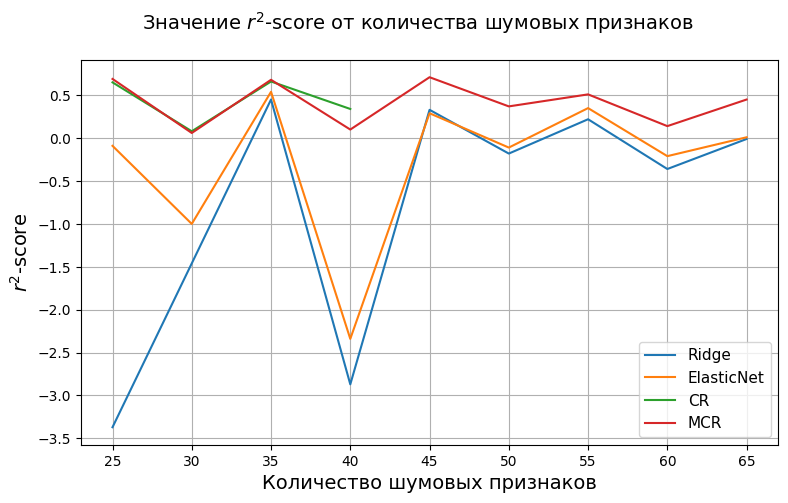

In [ ]:
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(9, 5)
fig.suptitle('Значение $r^2$-score от количества шумовых признаков', fontsize=14)

x_1 = list(range(25, 70, 5))
x_1_vpk = list(range(25, 45, 5))
axs.plot(x_1, r2_list_5_ridge, label='Ridge')
axs.plot(x_1, r2_list_5_elastic, label='ElasticNet')
axs.plot(x_1_vpk, r2_list_5_vpk, label='CR')
axs.plot(x_1, r2_list_5_mcr, label='MCR')

plt.grid()
axs.set_xlabel('Количество шумовых признаков', fontsize=14)
axs.set_ylabel('$r^2$-score', fontsize=14)
plt.legend(loc=4, fontsize=11)
plt.savefig("compare_models.svg")

# Эксперимент 3. Подбор количества эпох

In [ ]:
vpk_r2_list_25 = []
vpk_time_list_25 = []

vpk_r2_list_35 = []
vpk_time_list_35 = []

vpk_r2_list_30 = []
vpk_time_list_30 = []

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(5, 25, seed=1)
num_features = X_train.shape[1]

for epoch_coeff in tqdm((0.25, 0.5, 0.75, 1, 2, 5, num_features)):
    np.random.seed(1)
    start = time.time()
    mcr = ModifiedConvexRegression(num_epochs=int(num_features * epoch_coeff))
    mcr.fit(X_train, y_train, X_valid, y_valid)
    y_pred_mcr = mcr.predict(X_test)
    end = time.time()
    r_2_mcr = round(r2_score(y_test, y_pred_mcr), 2)
    time_mcr = end - start
    vpk_r2_list_25.append(r_2_mcr)
    vpk_time_list_25.append(time_mcr)

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
 14%|█▍        | 1/7 [00:06<00:41,  6.87s/it]


KeyboardInterrupt: 

In [ ]:
vpk_r2_list_25 = [0.52, 0.69, 0.71, 0.69, 0.69, 0.7, 0.68]

In [ ]:
vpk_time_list_25 = [7.956491708755493,
 13.425865173339844,
 8.77297830581665,
 9.918835401535034,
 19.541483163833618,
 42.50469207763672,
 207.2590136528015]

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(5, 35, seed=1)
num_features = X_train.shape[1]

for epoch_coeff in tqdm((0.25, 0.5, 0.75, 1, 2, 5, num_features)):
    np.random.seed(1)
    start = time.time()
    mcr = ModifiedConvexRegression(num_epochs=int(num_features * epoch_coeff))
    mcr.fit(X_train, y_train, X_valid, y_valid)
    y_pred_mcr = mcr.predict(X_test)
    end = time.time()
    r_2_mcr = round(r2_score(y_test, y_pred_mcr), 2)
    time_mcr = end - start
    vpk_r2_list_35.append(r_2_mcr)
    vpk_time_list_35.append(time_mcr)

In [ ]:
vpk_r2_list_35 = [0.66, 0.65, 0.64, 0.68, 0.65, 0.74, 0.73]

In [ ]:
vpk_time_list_35 = [4.048474311828613,
 8.645368576049805,
 12.10101866722107,
 15.290427923202515,
 30.067282676696777,
 69.82249164581299,
 556.764954328537]

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_data(10, 25, seed=1)
num_features = X_train.shape[1]

for epoch_coeff in tqdm((0.25, 0.5, 0.75, 1, 2, 5, num_features)):
    np.random.seed(1)
    start = time.time()
    mcr = ModifiedConvexRegression(num_epochs=int(num_features * epoch_coeff))
    mcr.fit(X_train, y_train, X_valid, y_valid)
    y_pred_mcr = mcr.predict(X_test)
    end = time.time()
    r_2_mcr = round(r2_score(y_test, y_pred_mcr), 2)
    time_mcr = end - start
    vpk_r2_list_30.append(r_2_mcr)
    vpk_time_list_30.append(time_mcr)

In [ ]:
vpk_r2_list_30 = [0.49, 0.56, 0.55, 0.54, 0.53, 0.54, 0.55]

In [ ]:
vpk_time_list_30 = [7.742231369018555,
 15.676585912704468,
 9.837647199630737,
 13.37260890007019,
 25.342735528945923,
 59.001163482666016,
 346.48700642585754]

<ipython-input-50-52618f9a8a49>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(x_ticks, rotation=75, fontsize=11)
<ipython-input-50-52618f9a8a49>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(x_ticks, rotation=75, fontsize=11)


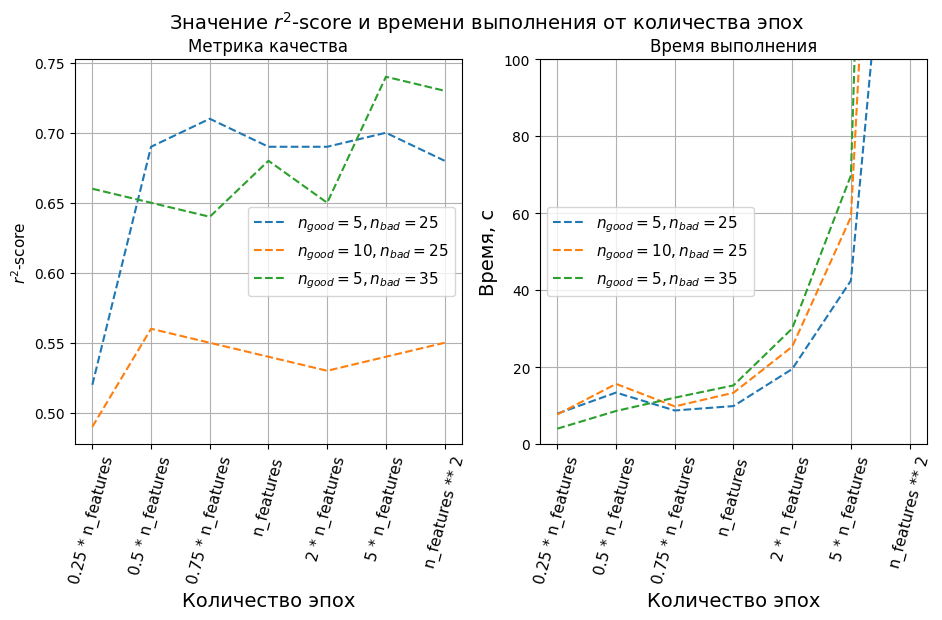

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(11, 5)
fig.suptitle('Значение $r^2$-score и времени выполнения от количества эпох', fontsize=14)

x_1 = list(range(7))
x_ticks = ['',
           '0.25 * n_features',
           '0.5 * n_features',
           '0.75 * n_features',
           'n_features',
           '2 * n_features',
           '5 * n_features',
           'n_features ** 2']
axs[0].plot(x_1, vpk_r2_list_25, label='$n_{good} = 5, n_{bad} = 25$', linestyle='--')
axs[0].plot(x_1, vpk_r2_list_30, label='$n_{good} = 10, n_{bad} = 25$', linestyle='--')
axs[0].plot(x_1, vpk_r2_list_35, label='$n_{good} = 5, n_{bad} = 35$', linestyle='--')
axs[0].set_title('Метрика качества')
axs[0].grid()
axs[0].legend(loc=5, fontsize=11)
axs[0].set_xticklabels(x_ticks, rotation=75, fontsize=11)
axs[0].set_xlabel('Количество эпох', fontsize=14)
axs[0].set_ylabel('$r^2$-score', fontsize=11)


axs[1].plot(x_1, vpk_time_list_25, label='$n_{good} = 5, n_{bad} = 25$', linestyle='--')
axs[1].plot(x_1, vpk_time_list_30, label='$n_{good} = 10, n_{bad} = 25$', linestyle='--')
axs[1].plot(x_1, vpk_time_list_35, label='$n_{good} = 5, n_{bad} = 35$', linestyle='--')
axs[1].set_title('Время выполнения')
axs[1].grid()
axs[1].legend(loc=6, fontsize=11)
axs[1].set_ylim([0, 100])
axs[1].set_xticklabels(x_ticks, rotation=75, fontsize=11)
axs[1].set_xlabel('Количество эпох', fontsize=14)
axs[1].set_ylabel('Время, с', fontsize=14)


plt.savefig("epoch.svg")

<ipython-input-77-dc8ceeb5bfc6>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(x_ticks_2, rotation=0, fontsize=11)


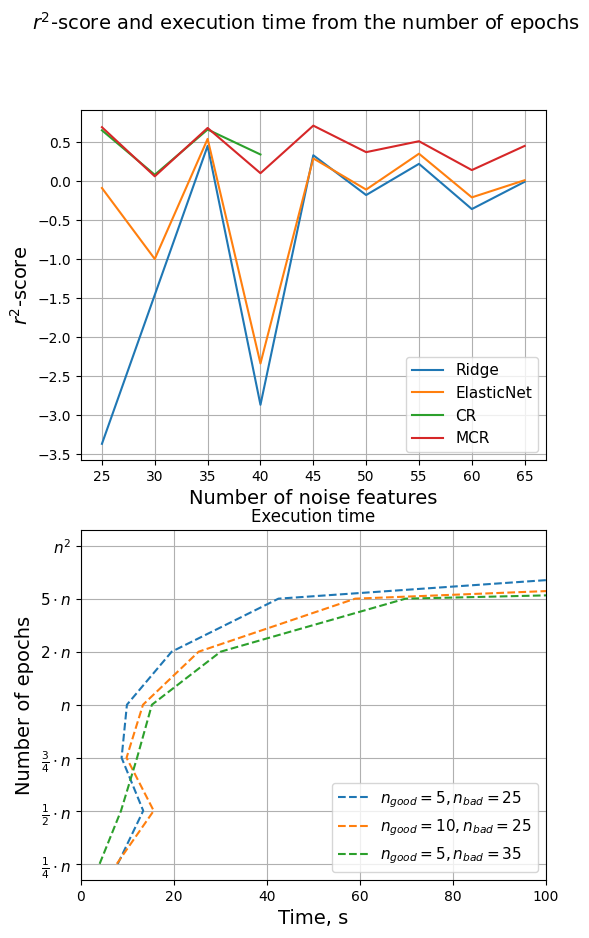

In [ ]:
fig, axs = plt.subplots(2, 1)
fig.set_size_inches(6, 10)
fig.suptitle('$r^2$-score and execution time from the number of epochs', fontsize=14)


x_1 = list(range(25, 70, 5))
x_1_vpk = list(range(25, 45, 5))
axs[0].plot(x_1, r2_list_5_ridge, label='Ridge')
axs[0].plot(x_1, r2_list_5_elastic, label='ElasticNet')
axs[0].plot(x_1_vpk, r2_list_5_vpk, label='CR')
axs[0].plot(x_1, r2_list_5_mcr, label='MCR')
axs[0].grid()
axs[0].set_xlabel('Number of noise features', fontsize=14)
axs[0].set_ylabel('$r^2$-score', fontsize=14)
axs[0].legend(loc=4, fontsize=11)


x_2 = list(range(7))
x_ticks_2 = ['',
           '$ \\frac{1}{4} \\cdot n$',
           '$ \\frac{1}{2} \\cdot n$',
           '$ \\frac{3}{4} \\cdot n$',
           '$n$',
           '$2 \\cdot n$',
           '$5 \\cdot n$',
           '$n^2$']

axs[1].plot(vpk_time_list_25, x_2, label='$n_{good} = 5, n_{bad} = 25$', linestyle='--')
axs[1].plot(vpk_time_list_30,x_2, label='$n_{good} = 10, n_{bad} = 25$', linestyle='--')
axs[1].plot(vpk_time_list_35,x_2, label='$n_{good} = 5, n_{bad} = 35$', linestyle='--')
axs[1].set_title('Execution time')
axs[1].grid()
axs[1].legend(loc=4, fontsize=11)
axs[1].set_xlim([0, 100])
axs[1].set_yticklabels(x_ticks_2, rotation=0, fontsize=11)
axs[1].set_ylabel('Number of epochs', fontsize=14)
axs[1].set_xlabel('Time, s', fontsize=14)


plt.savefig("m1p.jpg")